# Inspecting knowledge base of training data

We want to see if the `feature layers` we are using for the ML crop/non-crop mask are actually useful for distinguishing the two classes. We can understand the knowledge base built by the training data in a couple of ways:

1. Plotting class-specific `box plots` for each feature layer.

2. Plot the class-specific `principal components` of each class e.g. PC1 vs PC2 as a scatter-plot


## Load modules

In [ ]:
# !pip install richdem

In [1]:
%matplotlib inline

import sys
import os
import xarray as xr
import subprocess as sp
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from feature_layer_extractions import crop_features

import warnings
warnings.filterwarnings("ignore")

sys.path.append('../Scripts')
from deafrica_classificationtools import collect_training_data 
from deafrica_bandindices import calculate_indices
from deafrica_temporal_statistics import xr_phenology, temporal_statistics

%load_ext autoreload
%autoreload 2

## Analysis Parameters

In [2]:
ncpus=int(float(sp.getoutput('env | grep CPU')[-4:]))
path = 'data/training_validation/cropmask_training_polys_test.shp'   
field = 'class'
products =  ['s2_l2a'] #['ga_ls8c_gm_2_annual']
time = ('2019-01', '2019-12')
custom_func = crop_features
reduce_func = None #'mean'
calc_indices = ['NDVI'] 
drop = False
zonal_stats = None #'median' 
resolution =  (-20, 20)

print('ncpus = '+str(ncpus))

ncpus = 15


## Collect training data

In [3]:
#open shapefile and ensure its in WGS84 coordinates
input_data = gpd.read_file(path).to_crs('epsg:4326')

#check the shapefile by plotting it
# map_shapefile(input_data, attribute=field)

In [4]:
# a datacube query object
query = {
    'time': time,
    'measurements': [
                     'blue',
                     'green',
                     'red',
                     'nir_1',
                     'swir_1',
                     'swir_2'
                    ],
    'resolution': resolution,
    'group_by' :'solar_day',
    'output_crs':'epsg:6933'
}


In [11]:
%%time
column_names, model_input = collect_training_data(ncpus=ncpus,
                                    gdf=input_data,
                                    products=products,
                                    dc_query=query,
                                    custom_func=custom_func,
                                    field=field,
                                    calc_indices=calc_indices,
                                    reduce_func=reduce_func,
                                    drop=drop,
                                    zonal_stats=zonal_stats)

print(column_names)

---

## Data Wrangling

**Seperate crop and non-crop classes**

In [6]:
crop = model_input[model_input[:,0]==1]
non_crop = model_input[model_input[:,0]==2]

**Convert into pandas dataframes for ease**

In [7]:
crop_df = pd.DataFrame(crop).rename(columns={i:column_names[i] for i in range(0,len(column_names))}).drop('class', axis=1)
non_crop_df = pd.DataFrame(non_crop).rename(columns={i:column_names[i] for i in range(0,len(column_names))}).drop('class', axis=1)

**Normalise values**

So they can all plot on the same graph. Normalize by min/max values

In [8]:
crop_df = (crop_df-crop_df.min())/(crop_df.max()-crop_df.min())
non_crop_df = (non_crop_df-non_crop_df.min())/(non_crop_df.max()-non_crop_df.min())

---
## Feature layer boxplots

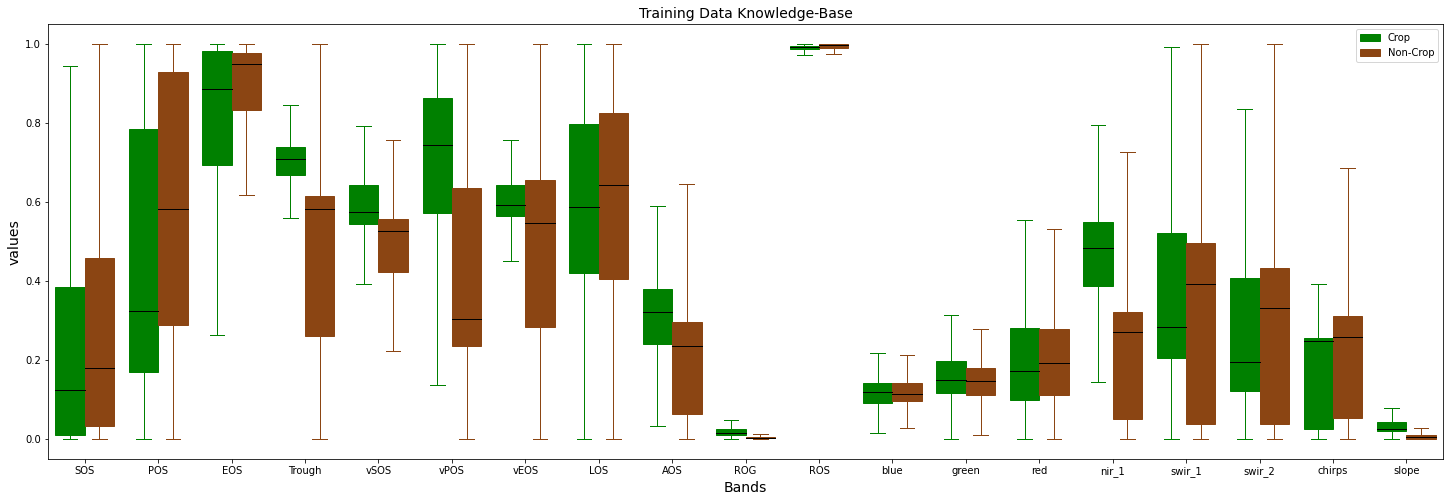

In [10]:
fig, ax = plt.subplots(figsize=(25,8))

crop_col ='green'
non_crop_col ='saddlebrown'

pp = ax.boxplot(crop_df.values,
                patch_artist=True,
                showfliers=False, 
                positions=np.arange(crop_df.values.shape[1])-.2, widths=0.4,
                boxprops=dict(facecolor=crop_col, color=crop_col),
                capprops=dict(color=crop_col),
                whiskerprops=dict(color=crop_col),
                flierprops=dict(color=crop_col, markeredgecolor=crop_col),
                medianprops=dict(color='black'))   

fp = ax.boxplot(non_crop_df.values,
                patch_artist=True, 
                showfliers=False,
                positions=np.arange(crop_df.values.shape[1])+.2, widths=0.4,
                boxprops=dict(facecolor=non_crop_col, color=non_crop_col),
                capprops=dict(color=non_crop_col),
                whiskerprops=dict(color=non_crop_col),
                flierprops=dict(color=non_crop_col, markeredgecolor=non_crop_col),
                medianprops=dict(color='black'))   

ax.set_xticks(np.arange(len(column_names[1:])))
ax.set_xticklabels(column_names[1:])
ax.set_xlim(-0.5,len(column_names[1:])-.5)
ax.set_ylabel("values", fontsize=14)
ax.set_xlabel("Bands", fontsize=14)
ax.set_title("Training Data Knowledge-Base", fontsize=14)
ax.legend([pp["boxes"][0], fp["boxes"][0]], ['Crop', 'Non-Crop'], loc='upper right')

plt.show()

---
## Principal Component Analysis

Conduct a PCA to determine the 

Need to standardize the values before conducting the PCA.
Couple of ways to do this, using `StandardScaler` for now i.e. `x-u/s`

In [12]:
# Put all the model TD into a pandas dataframe
all_data = pd.DataFrame(model_input).rename(columns={i:column_names[i] for i in range(0,len(column_names))})

In [13]:
# Separating out the features
x = all_data.loc[:, column_names[1:]].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

In [15]:
#conduct the PCA
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(x)

#add back to df
pca_df = pd.DataFrame(data = pca_fit,
                      columns = ['PC1', 'PC2'])

# concat with classes
df = pd.concat([pca_df, all_data[['class']]], axis = 1)

In [16]:
a,b = pca.explained_variance_ratio_
print("Variance explained by two principal components = " + str(round((a+b)*100, 2))+" %")

Variance explained by two principal components = 53.7 %


### Plot the principal components

Only plot a random subsample of the dataset as its huge

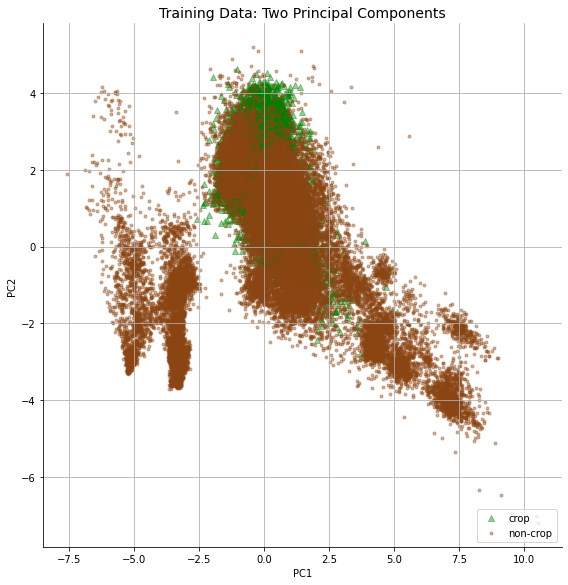

In [18]:
num_of_points = 50000

sns.lmplot(x="PC1", y="PC2",
           data=df.sample(n=num_of_points),
           fit_reg=False,
           hue='class',
           legend=False,
           size=8,
           scatter_kws={'alpha':0.4},
           markers=["^", "."],
           palette=['green', 'saddlebrown'])

plt.legend(('crop', 'non-crop'), loc='lower right')
plt.title('Training Data: Two Principal Components', fontsize=14)
plt.grid();